# Определение стоимости автомобилей

## Описание проекта

**Заказчик**: компания по продаже автомобилей с пробегом «Не бит, не крашен»

**Дано**: технические характеристики, комплектации и цены автомобилей

**Описание данных**:

    DateCrawled — дата скачивания анкеты из базы
    VehicleType — тип автомобильного кузова
    RegistrationYear — год регистрации автомобиля
    Gearbox — тип коробки передач
    Power — мощность (л. с.)
    Model — модель автомобиля
    Kilometer — пробег (км)
    RegistrationMonth — месяц регистрации автомобиля
    FuelType — тип топлива
    Brand — марка автомобиля
    NotRepaired — была машина в ремонте или нет
    DateCreated — дата создания анкеты
    NumberOfPictures — количество фотографий автомобиля
    PostalCode — почтовый индекс владельца анкеты (пользователя)
    LastSeen — дата последней активности пользователя
    Целевой признак:
    Price — цена (евро)


**Задача**:  построить модель для определения стоимости автомобиля. 

**Бизнес-цель**: привлечение новых клиентов с помощью приложения.

При разработке модели обратить внимание на:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Анализ общей информации

In [1]:
# Установим библиотеки, которых нет на сервере
!pip install catboost -q
!pip install missingno -q
# Библиотека pandas-profiling не всегда устанавливается стабильно, поэтому принудительно зададим стабильные версии
!pip install pandas_profiling==1.4.1 -q
!pip install pandas==0.25.3 -q
# Обновим версию scikit-learn для корректной работы RandomizedSearchCV
!pip install -U scikit-learn -q

Библиотека pandas_profiling поможет в проведении более тщательного EDA анализа. Исследовательский анализ можно делать и с помощью ручного вызова функций дефолтных библиотек. Данные библиотеки выбраны для максимизации комфорта презентации результатов анализа бизнес-пользователям.

In [2]:
# Импортируем библиотеки, с помощью которых будем обрабатывать данные

# Игнорирование предупреждений об ошибках
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display

# EDA анализ 
import pandas_profiling

# Работа с данными
import pandas as pd 
import numpy as np
import random
import timeit

# Визуализация данных
import matplotlib.pyplot as plt 
import seaborn as sns
import missingno as msno 
%matplotlib inline

# Предобработка
from sklearn.preprocessing import LabelEncoder #кодирование
from sklearn.impute import MissingIndicator #индикатор пропусков
from sklearn.model_selection import train_test_split #разделение на выборки

# Модели
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

# Подбор гиперпараметров и лучшей модели
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV, cross_val_score


# Метрики
from sklearn.metrics import mean_squared_error, make_scorer

# Установка настроек для отображения всех колонок и строк при печати
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Настройки для печати нескольких выводов данных в одной ячейке
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

SEED = 42

In [3]:
# Блок самописных функций используемых в проекте

def missing_flag(feature):
    """
    На вход принимает признак у которого есть пропуски, значение типа str
    Создает экземпляр класса MissingIndicator
    Обучает модель импутации
    Применяет обученную модель импутации к принятой переменной
    Результат сохраняет в новой колонке под названием имя_переменной+_flag
    """    
    miss_ind = MissingIndicator()
    miss_ind.fit(df[[feature]])
    df[feature + '_flag'] = miss_ind.transform(df[[feature]])
    
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)**0.5

def modeling(model, name, prep_time, X_train, y_train, X_test, y_test, 
             lgbm_model=False, cb=False):
    
    # Обучаем модель
    start = timeit.default_timer()
    if lgbm_model:
        model.fit(X_train, y_train, eval_set = (X_test,y_test), eval_metric = 'RMSE', verbose = 100)
    elif cb:
        model.fit(X_train, y_train, verbose = False)
    else:
        model.fit(X_train, y_train)
    stop = timeit.default_timer()

    fit_time = round(stop - start, 4)
        
    # Получаем предсказания на тестовой выборке
    start = timeit.default_timer()
    predict = model.predict(X_test)
    stop = timeit.default_timer()

    pred_time = round(stop - start, 4)
        
    # Проверяем метрику получившейся модели
    rmse_res = round(rmse(y_test, predict), 2)
        
    # Соберем в список всю информацию по модели
    lst_const = [name, prep_time, fit_time, pred_time, rmse_res]
    
    return model, lst_const

def encoding_LE(X_train, X_test):
    
    start = timeit.default_timer()
    X_train_le = X_train.copy()
    X_test_le = X_test.copy()

    for category in cat_columns:
        le = LabelEncoder()
        X_train_le[category] = le.fit_transform(X_train_le[category])
        X_test_le[category] = le.transform(X_test_le[category])

    stop = timeit.default_timer()

    prep_time_le = round(stop - start, 4)
    
    return X_train_le, X_test_le, prep_time_le

def feature_importances(model, X_train):
    importances = pd.DataFrame(model.feature_importances_, index = X_train.columns, columns=['Importance'])
    sns.barplot(data=importances, x='Importance', y=importances.index, 
                order = importances.sort_values(by='Importance', ascending = False).index)
    plt.title('Feature Importances');

Считываем данные

In [4]:
# Прочитаем данные и запишем в переменную df
name = 'autos.csv'

try: 
    df = pd.read_csv('datasets\\{}'.format(name))
except:
    print(print('Файл {} не найден и будет скачиваться по сети.'.format(name)))
    df = pd.read_csv('https://code.s3.yandex.net/datasets/{}'.format(name))    

Файл autos.csv не найден и будет скачиваться по сети.
None


Запусим библиотеку pandas_profiling и посмотрим как выглядят статистики

In [5]:
pandas_profiling.ProfileReport(df)

Number of variables,16
Number of observations,354369
Total Missing (%),3.2%
Total size in memory,43.3 MiB
Average record size in memory,128.0 B
Numeric,6
Categorical,9
Boolean,0
Date,0
Text (Unique),0
Rejected,1


Инструмент pandas_profiling позволяет изучить основную информацию о значениях и статистиках по признакам. Автоматический анализатор позволяет быстро получить информацию о типах данных, распределениях, наличиях пропусков и дублей в наборе данных. Так же можно увидеть информацию о корреляции между признаками или признаками и целевой переменной. Данный инструмент не позволяет ответить на все вопросы о наших данных, но помогает довольно быстро оценить основные проблемы, присутствующие в данных и определиться с инструментами для более детального анализа.

Анализ текущих данных в pandas_profiling показал:

- имеются дубликаты
- признак `NumberOfPictures`- все значения равны нулю
- при подготовке данных вероятно допущена ошибка при формировании признака `DateCreated` - совпадает с датой скачивания анкеты из базы, но время пустое, данный признак не информативен.
- нулевые значения в признаках:

    `Price` - 10772 (3.0%)  
    `Power` - 40225 (11.4%)  
    `RegistrationMonth` - 37352 (10.5%)  


- некорректный тип данных для признаков (object -> DataTime) `DateCrawled`, `LastSeen` 

In [6]:
# Посмотрим сколько в наших данных пропущенных значений и их доли от общего количества значений 
isnull = df.isnull().sum()
notnull = df.notnull().sum()
percent = (round(df.isnull().sum()/df.isnull().count()*100, 1)).sort_values(ascending=False)
missing_data = pd.concat([isnull, notnull, percent], axis=1, keys=['Есть пропуски', "Нет пропусков", 'Процент пропусков'])
missing_data.sort_values(by='Процент пропусков', ascending=False)

,Есть пропуски,Нет пропусков,Процент пропусков
NotRepaired,71154,283215,20.1
VehicleType,37490,316879,10.6
FuelType,32895,321474,9.3
Gearbox,19833,334536,5.6
Model,19705,334664,5.6
Brand,0,354369,0.0
DateCrawled,0,354369,0.0
DateCreated,0,354369,0.0
Kilometer,0,354369,0.0
LastSeen,0,354369,0.0


Визуализируем пропуски в данных с целью нахождения закономерностей

<AxesSubplot:>

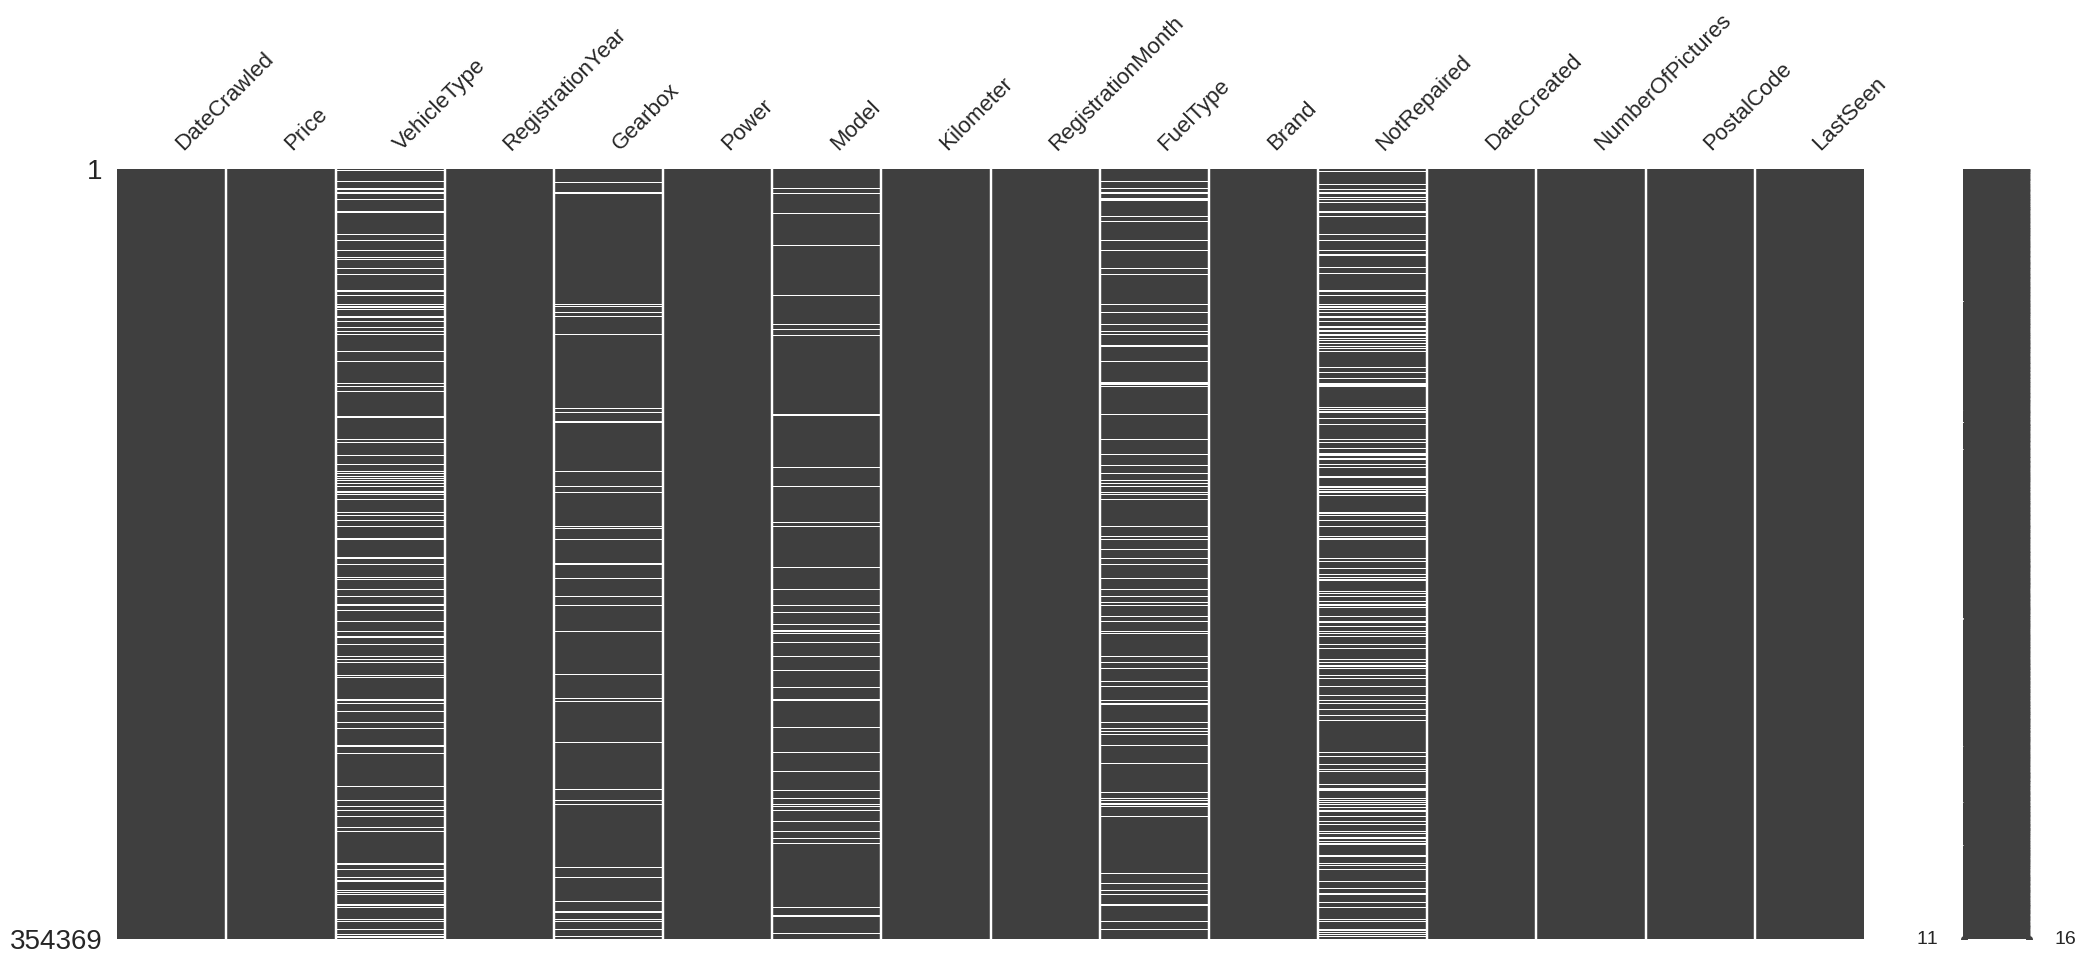

In [7]:
msno.matrix(df)

Явных паттернов в пропуках нет, из чего делаем вывод, что пропуски имеют случайную природу.

**Вывод**

Анализ данных выявил ряд проблем в данных, которые требуется скорректировать следующим образом:

- преобразовать тип данных object -> DataTime для признаков `DateCrawled`, `LastSeen`
- удалить признак `NumberOfPictures` - признак не содержит значений
- удалить признак `PostalCode` - признак не содержит информации важной для текущей постановки задачи
- удалить признак `DateCreated`
- удалить выявленные дубликаты
- перед заполнением пропусков на каждую колонку с пропусками добавить колонку "флаг" типа bool - есть/нет пропуск
- пропуски в признаках `VehicleType`, `Gearbox`, `Model`, `FuelType`, `NotRepaired` заменить на 'другое'
- в признаке `Price` удалить нули и значения ниже 100
- в признаке `Power` удалить значения выходящие вне диапозона 20-500
- в признаке `RegistrationYear` удалить значения выходящие за диапозон 1900-2020
- в случае использования модели линейной регрессии сделать стандартизацию: преобразование с помощью LabelEncoding

## Предобработка данных

Удалим строки с дубликатами и сбросим индексы

In [8]:
df = df.drop_duplicates(keep='first').reset_index(drop=True)

Проверим что дубликаты удалены

In [9]:
df.duplicated().sum()

0

Удалим колонки `NumberOfPictures` и `DateCreated`

In [10]:
df = df.drop(['NumberOfPictures', 'DateCreated', 'PostalCode'], axis=1)

Вызовем функцию missing_flag для признаков `VehicleType`, `Gearbox`, `Model`, `FuelType`, `NotRepaired`

In [11]:
for column_name in ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']:
    missing_flag(column_name)

Преобразуем тип данных для признаков хранящих даты

In [12]:
df['DateCrawled'] = pd.to_datetime(df['DateCrawled']).astype(np.int64) // 10 ** 9
df['LastSeen'] = pd.to_datetime(df['LastSeen']).astype(np.int64) // 10 ** 9

Пропуски в признаках `VehicleType`, `Gearbox`, `Model`, `FuelType`, `NotRepaired` заменим на 'другое'

In [13]:
for column in ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired']:
    df[column] = df[column].fillna('другое')

In [14]:
df.describe()

,DateCrawled,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,LastSeen
count,3.543650e+05,354365.000000,354365.000000,354365.000000,354365.000000,354365.000000,3.543650e+05
mean,1.458565e+09,4416.679830,2004.234481,110.093816,128211.363989,5.714650,1.459295e+09
std,7.864397e+05,4514.176349,90.228466,189.851330,37905.083858,3.726432,7.933289e+05
min,1.457187e+09,0.000000,1000.000000,0.000000,5000.000000,0.000000,1.457187e+09
25%,1.457870e+09,1050.000000,1999.000000,69.000000,125000.000000,3.000000,1.458701e+09
50%,1.458583e+09,2700.000000,2003.000000,105.000000,150000.000000,6.000000,1.459697e+09
75%,1.459262e+09,6400.000000,2008.000000,143.000000,150000.000000,9.000000,1.459938e+09
max,1.460040e+09,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,1.460041e+09


Считается хорошим тоном, совместно со статистическим анализом проводить бизнес-анализ данных.   
Для определения минимального порога по цене был проанализирован сайт https://www.ooyyo.com/ на котором для нескольких стран был установлен фильтр по цене. Минимальное выявленное значение: 100 евро.  
Исследование по возможным мощностям автомобилей показало, что несмотря на наличие маломощных автомобилей (примерно 10 моделей в мире, которые имеют показатели ~10 л/с), такие значения редки. За основу определения корректного диапазона взято исследование автомобильного рынка, на основании которого выбран диапазон допустимых значений, без аномальных выбросов.     
Последняя дата регистрации на сайте - 2016 год. Предположительно, всё что больше 2016 - аномалии.
Для определения нижней отсечки по году требуется обсуждение с бизнесом на предемет - какие машины будут в сервисе(ретро, любые или только не старше определенного возраста). На текущий момент принято решение установить отсечку на уровне 1900, чтобы не ограничивать рассматриваемые категории.  

In [15]:
df = df.query('Price >= 100')
df = df.query('30 <= Power <= 500')
df = df.query('1900 <= RegistrationYear <= 2016')

In [16]:
df.describe()

,DateCrawled,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,LastSeen
count,2.944980e+05,294498.000000,294498.000000,294498.000000,294498.000000,294498.000000,2.944980e+05
mean,1.458566e+09,4874.605940,2002.872576,120.838162,128449.191506,6.001759,1.459315e+09
std,7.877513e+05,4610.845081,6.443240,53.327688,36561.743509,3.580099,7.865808e+05
min,1.457187e+09,100.000000,1910.000000,30.000000,5000.000000,0.000000,1.457187e+09
25%,1.457869e+09,1350.000000,1999.000000,77.000000,125000.000000,3.000000,1.458741e+09
50%,1.458583e+09,3200.000000,2003.000000,112.000000,150000.000000,6.000000,1.459740e+09
75%,1.459263e+09,6999.000000,2007.000000,150.000000,150000.000000,9.000000,1.459940e+09
max,1.460040e+09,20000.000000,2016.000000,500.000000,150000.000000,12.000000,1.460041e+09


**Вывод**

- удалены признаки `NumberOfPictures` и `DateCreated`
- удалены выявленные дубликаты
- для признаков `VehicleType`, `Gearbox`, `Model`, `FuelType`, `NotRepaired` добавлена колонка-флаг наличия пропуска 
- пропуски в признаках `VehicleType`, `Gearbox`, `Model`, `FuelType`, `NotRepaired` заменены на 'другое'
- удалены значения признаков `Power`, `Price`, `RegistrationYear` выходящие за адекватный диапазоны

## Прототипирование

### Разбиение данных на выборки

В переменную features поместим датасет удалив колонку Price. Отделим от датасета колонку Price с целевой переменной и поместим её в переменную target

In [17]:
features = df.drop(['Price'], axis=1)
target = df['Price']

Поделим данные на обучающую и тестовую выборки

In [18]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.25, random_state=SEED)

Создадим списки категориальных и количественных переменных

In [19]:
cat_columns = X_train.dtypes[X_train.dtypes == 'object'].index.tolist()
num_columns = X_train.dtypes[X_train.dtypes != 'object'].index.tolist()

Удалим из списка количественных переменных переменные содержащие даты

In [20]:
date_columns = ['DateCrawled', 'LastSeen']
num_columns = list(set(num_columns).difference(set(date_columns)))

Посмотрим итоговый список категориальных переменных

In [21]:
num_columns

['Power',
 'NotRepaired_flag',
 'FuelType_flag',
 'RegistrationYear',
 'Kilometer',
 'RegistrationMonth',
 'Model_flag',
 'Gearbox_flag',
 'VehicleType_flag']

### Константная модель

Запуск константной модели для возможности проверки последующих моделей на адекватность. Предсказание - медиана обучающей выборки

Инициализируем модель

In [22]:
model_const = DummyRegressor(strategy="median")

Вызовем функцию по обучению модели. Зафиксируем время, потребовавшееся для подготовки признаков, перед использованием модели - 0

In [23]:
prep_time = 0.0
model_const, lst_const = modeling(model_const, 'Constant model', prep_time, X_train, y_train, X_test, y_test)

### Random Forest Regressor

Проверим простую модель Random Forest Regressor. Для нее понадобится обработать категориальные признаки - применим метод LabelEncoder.

In [24]:
X_train_le, X_test_le, prep_time_le = encoding_LE(X_train, X_test)

Инициализируем модель

In [25]:
model_rfr = RandomForestRegressor(random_state=SEED)

Вызовем функцию по обучению модели

In [26]:
model_const, lst_rfr = modeling(model_rfr, 'Random Forest Regressor', prep_time_le, X_train_le, y_train, X_test_le, y_test)

Посмотрим на top важных признаков

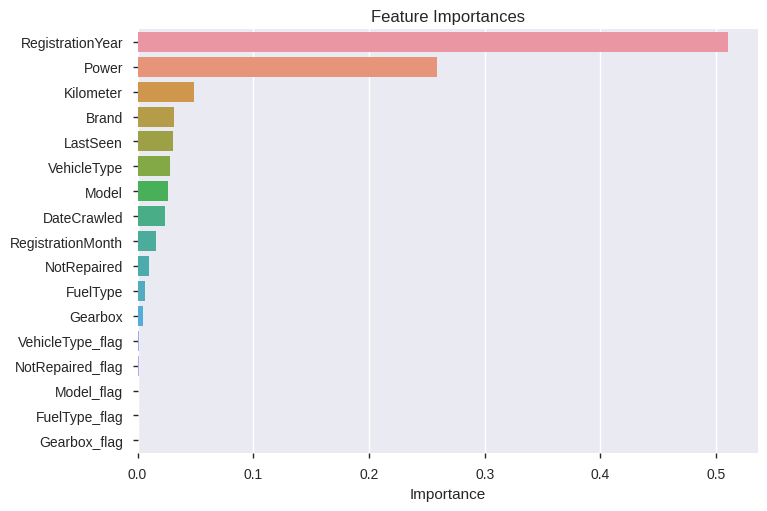

In [27]:
feature_importances(model_rfr, X_train)

Подберем параметры для модели Random Forest Regressor с помощью Randomized SearchCV

In [28]:
model_rfr_rs = RandomForestRegressor(random_state=SEED)

kf = KFold(n_splits=3, random_state=SEED, shuffle=True)

param_grid = {'max_depth': [10, 20, 50],
              'min_samples_split' : [7, 10, 12]}

rmse_rs = make_scorer(rmse)

rs = RandomizedSearchCV(model_rfr_rs, 
                   param_grid, 
                   scoring=rmse_rs, 
                   cv=kf,
                   n_jobs=-1,)

start = timeit.default_timer()
rs.fit(X_train_le, y_train)
stop = timeit.default_timer()
fit_time_rs = round(stop - start, 4)
print('Время подбора оптимальных параметров для Random Forest Regressor с подобранными поиском по сетке параметрами: ', fit_time_rs)


print('Наилучшие значения гиперпараметров: {}'.format(rs.best_params_))

start = timeit.default_timer()
predict_rs = rs.best_estimator_.predict(X_test_le)
stop = timeit.default_timer()
pred_time_rs = round(stop - start, 4)
print('Время предсказания Random Forest Regressor с подобранными поиском по сетке параметрами: ', pred_time_rs)


# Проверяем метрику получившейся модели
rmse_rs = round(rmse(y_test, predict_rs), 2)
print('RMSE Random Forest Regressor с подобранными поиском по сетке параметрами на тестовой выборке:', rmse_rs)

# Соберем в список всю информацию по модели
lst_rfr_rs = ['Random Forest Regressor_RS', prep_time_le, fit_time_rs, pred_time_rs, rmse_rs]

RandomizedSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
                   estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 50],
                                        'min_samples_split': [7, 10, 12]},
                   scoring=make_scorer(rmse))

Время подбора оптимальных параметров для Random Forest Regressor с подобранными поиском по сетке параметрами:  1589.0991
Наилучшие значения гиперпараметров: {'min_samples_split': 12, 'max_depth': 10}
Время предсказания Random Forest Regressor с подобранными поиском по сетке параметрами:  0.6626
RMSE Random Forest Regressor с подобранными поиском по сетке параметрами на тестовой выборке: 1849.22


Посмотрим на top важных признаков

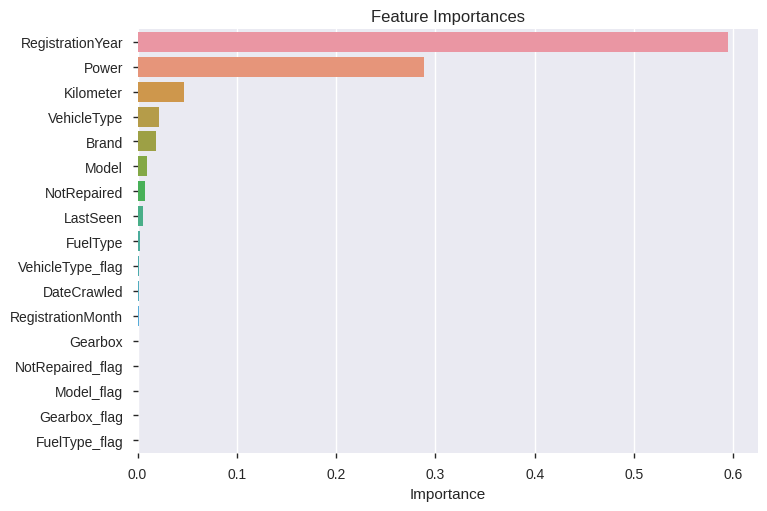

In [29]:
model_rfr_rs = rs.best_estimator_.fit(X_train_le, y_train)

feature_importances(model_rfr_rs, X_train)

### LGBM

Запустим модель LightGBM. Для нее тоже необходимо обрабатывать категориальные признаки с помощью метода LabelEncoder (реализовано ранее).

Зададим параметры для модели

In [30]:
lgbm = LGBMRegressor(depth = 10, n_estimators = 1000, learning_rate = 0.1, random_state = SEED, verbose = 100)

Обучим модель

In [32]:
model_lgbm, lst_lgbm = modeling(lgbm, 'LightGBM', prep_time_le, X_train_le, y_train, X_test_le, y_test, lgbm_model=True)

[100]	valid_0's rmse: 1641.51	valid_0's l2: 2.69455e+06
[200]	valid_0's rmse: 1571.54	valid_0's l2: 2.46973e+06
[300]	valid_0's rmse: 1545.39	valid_0's l2: 2.38822e+06
[400]	valid_0's rmse: 1527.86	valid_0's l2: 2.33435e+06
[500]	valid_0's rmse: 1513.94	valid_0's l2: 2.29201e+06
[600]	valid_0's rmse: 1503.98	valid_0's l2: 2.26197e+06
[700]	valid_0's rmse: 1497.58	valid_0's l2: 2.24274e+06
[800]	valid_0's rmse: 1491.98	valid_0's l2: 2.22602e+06
[900]	valid_0's rmse: 1488.13	valid_0's l2: 2.21454e+06
[1000]	valid_0's rmse: 1483.96	valid_0's l2: 2.20214e+06


Посмотрим на top важных признаков 

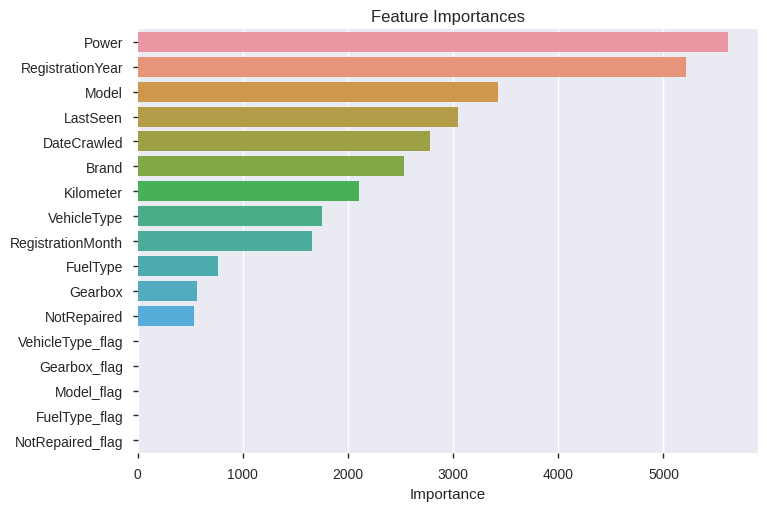

In [33]:
feature_importances(lgbm, X_train_le)

### CatBoost

Запустим модель CatBoost.

Обучим модель

In [34]:
model_cb = CatBoostRegressor(iterations=200, eval_metric='RMSE', learning_rate=0.1, random_seed=SEED, logging_level='Silent')

model_cb, lst_cb = modeling(model_cb, 'CatBoostRegressor', prep_time_le, X_train_le, y_train, X_test_le, y_test, cb=True)

Посмотрим на top важных признаков

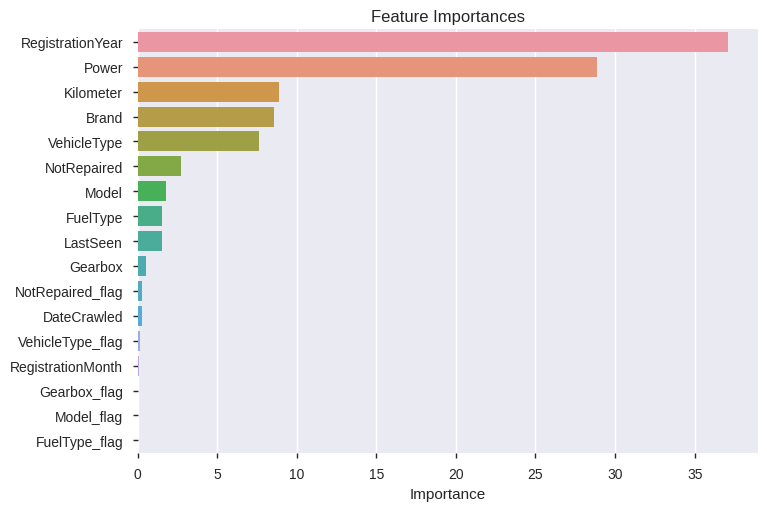

In [35]:
feature_importances(model_cb, X_train)

## Общий вывод

Соберем итоговую таблицу по моделям

In [36]:
res_lst = [lst_const, lst_rfr, lst_lgbm, lst_cb]
result_df = pd.DataFrame(res_lst,
                   columns=['Модель', 'Время на подготовку признаков, сек.', 'Скорость обучения, cек.', 'Скорость предсказания, cек.', 'Качество предсказания  (RMSE)'])
result_df.sort_values(by='Качество предсказания  (RMSE)')

,Модель,"Время на подготовку признаков, сек.","Скорость обучения, cек.","Скорость предсказания, cек.",Качество предсказания (RMSE)
2,LightGBM,0.4146,49.4870,5.6290,1483.96
1,Random Forest Regressor,0.4146,123.5606,3.7124,1560.10
3,CatBoostRegressor,0.4146,23.3260,0.0742,1671.74
0,Constant model,0.0000,0.0032,0.0003,4913.09


Произведена предобработка данных - данные содержали пропущенные значения и значения не соответствующие адекватным диапазонам.
Произведена подготовка данных для моделирования и предподготовка в соответствии с требованиями моделей.
Продемонстрировано обучение моделей Random Forest Regressor, LightGBM, CatBoost.
В сравнении с константной моделью, они все показали более высокие результаты - модели адекватны.

Сравнение по скорости показало, что быстрее всего отрабатывает Константная модель.
Сравнение по качеству метрики RMSE показало, что лучшее качество у модели LGBM.
Для моделей требуется дополнительная предподготовка признаков, которая тоже может занимать время.